# Ui-Wing Cheah
## EN 625.633 Module 11 Assignment

In [1]:
# imports
import scipy.stats as sp 
import numpy as np 
import statsmodels.api as smapi 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [2]:
# getting the salmon data
# we take the data from the R file and put it in an Excel File
# since the data set was small we did this manually
# for large data sets we would parse the original R file directly
src = 'c:/Users/nowuc/Code/data/salmon_data.xlsx'
xl_file = pd.ExcelFile(src)
salmon_data = xl_file.parse('salmon_data')
salmon_data.head()

,R,S
0,68,56
1,77,62
2,299,445
3,220,279
4,142,138


In [3]:
salmon_data.describe()

,R,S
count,40.000000,40.000000
mean,206.925000,272.850000
std,70.428865,129.792843
min,64.000000,51.000000
25%,164.750000,172.500000
50%,217.000000,274.500000
75%,269.000000,393.500000
max,311.000000,490.000000


In [25]:
# functions and classes
# show the results and also find the point where R=S
est_sustain = lambda beta: (1-beta[1])/beta[0]
est_R = lambda beta,S:1/(beta[0]+beta[1]/S)

# create bootstrap engine
def bootstrap_pairs(y_data,x_data,B=200,*args,**kwargs):
    all_data = np.array([y_data,x_data]).transpose()
    #initializing and empty set
    bhats = np.zeros((B,2))
    # creating samples of data
    for b_ in range(B):
        idx_rand = np.random.choice(range(len(all_data)),size=len(all_data))
        x_y_rand = all_data[idx_rand]
        y_rand = x_y_rand[:,0].reshape(-1,)
        x_rand = x_y_rand[:,1].reshape(-1,)
        x_reg = smapi.add_constant(x_rand)
        model = smapi.OLS(y_rand,x_reg)
        model_results = model.fit()
        bhats[b_,:]=model_results.params
    return bhats

# create bootstrap engine
def bootstrap_resid(resid,beta,x_data,B=200,*args,**kwargs):
    x_var = smapi.add_constant(x_data)
    #initializing and empty set
    bhats = np.zeros((B,2))
    # creating samples of data
    beta = beta.reshape(-1,1)
    y_hat = x_var.dot(beta).reshape(-1,)

    for b_ in range(B):
        resid_rand = np.random.choice(resid,len(resid))
        y_rand = y_hat+resid_rand
        model = smapi.OLS(y_rand,x_var)
        model_results = model.fit()
        bhats[b_,:]=model_results.params
    return bhats



In [7]:
# set up a simple linear regression model for the whole sample. 
# getting the reciprocals
x_data = 1/salmon_data['S'].values
y_var = 1./salmon_data['R'].values
x_var = smapi.add_constant(x_data)

# regression model
lm_1 = smapi.OLS(y_var,x_var,)
lm_1_results = lm_1.fit()
bhat = lm_1_results.params
print('Regression coefficients:{0}'.format(bhat))
R_fit = est_R(bhat,salmon_data['S'].values)
R_sustain = est_sustain(bhat)
print(R_sustain)

Regression coefficients:[0.00201323 0.69781884]
150.0976343009784


### Part a

In [62]:
b_pairs = bootstrap_pairs(y_var,x_data,)
print(b_pairs.mean(axis=0))

[0.0020227  0.69675418]


Text(0, 0.5, 'Frequency')

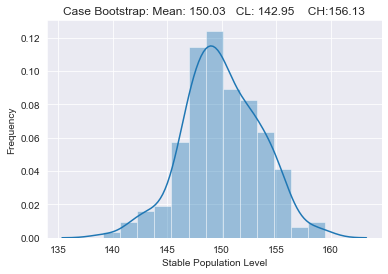

In [136]:
r_bstrap_pairs = pd.Series(np.array([est_sustain(j) for j in b_pairs]))
title = 'Case Bootstrap: Mean: {0:.2f}   CL: {1:.2f}    CH:{2:.2f}'.format(r_bstrap_pairs.mean(),r_bstrap_pairs.quantile(0.025),r_bstrap_pairs.quantile(0.975))
results_pairs = pd.Series({'Mean':r_bstrap_pairs.mean(),'CL': r_bstrap_pairs.quantile(0.025),'CH':r_bstrap_pairs.quantile(0.975)})
ax_ = sns.distplot(r_bstrap_pairs)
ax_.set_title(title)
ax_.set_xlabel('Stable Population Level')
ax_.set_ylabel('Frequency')

In [76]:
# bootstrap residuals
resid_vec = lm_1_results.resid
b_resid = bootstrap_resid(resid_vec,bhat,x_data,)
print(b_resid.mean(axis=0))


[0.00201063 0.69794885]


Text(0, 0.5, 'Frequency')

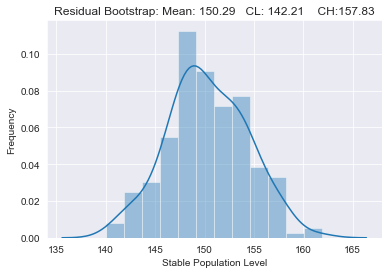

In [137]:
# Plotting residual bootstrap results
r_bstrap_resid = pd.Series(np.array([est_sustain(j) for j in b_resid]))
title = 'Residual Bootstrap: Mean: {0:.2f}   CL: {1:.2f}    CH:{2:.2f}'.format(r_bstrap_resid.mean(),r_bstrap_resid.quantile(0.025),r_bstrap_resid.quantile(0.975))
results_resid = pd.Series({'Mean':r_bstrap_resid.mean(),'CL':r_bstrap_resid.quantile(0.025),'CH':r_bstrap_resid.quantile(0.975)})
ax_ = sns.distplot(r_bstrap_resid)
ax_.set_title(title)
ax_.set_xlabel('Stable Population Level')
ax_.set_ylabel('Frequency')

In [141]:
results = pd.DataFrame({'Resid': results_resid,'Cases':results_pairs})
print(results.round(decimals=2))
print(results.round(decimals=2).to_latex())

Resid   Cases
Mean  150.29  150.03
CL    142.21  142.95
CH    157.83  156.13
\begin{tabular}{lrr}
\toprule
{} &   Resid &   Cases \\
\midrule
Mean &  150.29 &  150.03 \\
CL   &  142.21 &  142.95 \\
CH   &  157.83 &  156.13 \\
\bottomrule
\end{tabular}



In [142]:
# summarizing the mean results
mres_resid = pd.Series({'E(R)': r_bstrap_resid.mean(), 'f(E(b))': est_sustain(b_resid.mean(axis=0))})
mres_cases = pd.Series({'E(R)': r_bstrap_pairs.mean(),'f(E(b))':est_sustain(b_pairs.mean(axis=0))})
r_summary = pd.DataFrame({'resid':mres_resid,'cases':mres_cases})
print(r_summary.round(decimals=2).to_latex())

\begin{tabular}{lrr}
\toprule
{} &   resid &   cases \\
\midrule
E(R)    &  150.29 &  150.03 \\
f(E(b)) &  150.23 &  149.92 \\
\bottomrule
\end{tabular}



Text(0.5, 1.0, 'Full Sample Regression: R vs S')

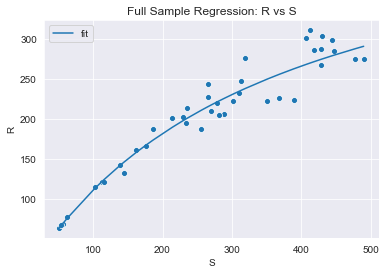

In [8]:
# creating line/scatter plot
sns.set_style('darkgrid')
ax_ = sns.scatterplot(data=salmon_data,x='S',y='R')
ax_ = sns.lineplot(x=salmon_data['S'].values,y=R_fit,label='fit',)
ax_.set_title('Full Sample Regression: R vs S')


In [9]:
print(lm_1_results.summary())

OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     3687.
Date:                Fri, 17 Apr 2020   Prob (F-statistic):           1.89e-39
Time:                        21:04:02   Log-Likelihood:                 264.18
No. Observations:                  40   AIC:                            -524.4
Df Residuals:                      38   BIC:                            -521.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020   8.22e-05     24.502      0.000       0.002       0.002
x

In [73]:
print(lm_1_results.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &        y         & \textbf{  R-squared:         } &     0.990   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.990   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     3687.   \\
\textbf{Date:}             & Tue, 14 Apr 2020 & \textbf{  Prob (F-statistic):} &  1.89e-39   \\
\textbf{Time:}             &     21:29:06     & \textbf{  Log-Likelihood:    } &    264.18   \\
\textbf{No. Observations:} &          40      & \textbf{  AIC:               } &    -524.4   \\
\textbf{Df Residuals:}     &          38      & \textbf{  BIC:               } &    -521.0   \\
\textbf{Df Model:}         &           1      & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
               & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\

In [ ]:
###

### Problem 2

In [149]:
# function to compute bootstrap and jackknife estimates for normal sample with a given function
def jackknife_array(n):
    ix = set([x for x in range(n)])
    idx = [sorted(ix.difference([x,])) for x in range(n)]
    return np.array(idx)

def bs_jack_norm(estimator_func, B=200,n=20):
    theta = 1
    # set the seed so we can replicate the results
    np.random.seed(1)
    sample_orig = sp.norm(loc=theta,scale=1).rvs(size=(100,n))
    
    bootstrap_var = np.zeros(len(sample_orig))
    jackknife_var = np.zeros(len(sample_orig))

    for isamp, current_sample in enumerate(sample_orig):
        # getting the B bootstraps for each sample
        bstraps = np.random.choice(current_sample,size=(B,n))
        bstrap_val = estimator_func(bstraps)
        bootstrap_var[isamp] = bstrap_val.var()

        # getting the jackknife sample
        jks = current_sample[jackknife_array(n)]
        jks_val = estimator_func(jks)
        jackknife_var[isamp] = (n-1)*jks_val.var(ddof=1)

    variance_results = pd.DataFrame({'Bootstrap': pd.Series(bootstrap_var),'Jackknife': pd.Series(jackknife_var)})
    return variance_results



In [150]:
estim_mean = lambda arr: arr.mean(axis=1)
results_2a = bs_jack_norm(estim_mean,)
summ_2a = pd.DataFrame({'mean':results_2a.mean(),'std':results_2a.std()})
print(summ_2a)
print(summ_2a.round(decimals=4).to_latex())

mean       std
Bootstrap  0.048842  0.017717
Jackknife  0.053624  0.018140
\begin{tabular}{lrr}
\toprule
{} &    mean &     std \\
\midrule
Bootstrap &  0.0488 &  0.0177 \\
Jackknife &  0.0536 &  0.0181 \\
\bottomrule
\end{tabular}



In [151]:
estim_meansq = lambda arr: pow(arr.mean(axis=1),2)
results_2b = bs_jack_norm(estim_meansq,)
summ_2b = pd.DataFrame({'mean':results_2b.mean(),'std':results_2b.std()})
print(summ_2b)
print(summ_2b.round(decimals=4).to_latex())

mean       std
Bootstrap  0.212834  0.100224
Jackknife  0.231038  0.109230
\begin{tabular}{lrr}
\toprule
{} &    mean &     std \\
\midrule
Bootstrap &  0.2128 &  0.1002 \\
Jackknife &  0.2310 &  0.1092 \\
\bottomrule
\end{tabular}



### Problem 3

In [124]:
def mean_diff(mu1=1.0,sig1=1.0,mu2=0.75,sig2=0.75,n=15,m=20,B=200,*args,**kwargs):
    np.random.seed(5)
    # distributions
    x_dist = sp.norm(loc=mu1,scale=sig1)
    y_dist = sp.norm(loc=mu2,scale=sig2)
    # generating random variables
    x_vec = x_dist.rvs(size=(n,))
    y_vec = y_dist.rvs(size=(m,))
    # getting the theoretical distribution of means
    t_dist = sp.t(df=n+m-1)
    t_ = t_dist.ppf(0.975)
    #t_cl =t_dist.ppf(0.025)
    # sample standard deviations
    s_x = x_vec.std(ddof=1)
    s_y = y_vec.std(ddof=1)
    x_y_diff = x_vec.mean()-y_vec.mean()
    t_stat = t_ * np.sqrt(pow(s_x,2)/n+pow(s_y,2)/m)
    conf_theoretical = pd.Series({'lower': x_y_diff-t_stat, 'upper': x_y_diff+t_stat,'mean':mu1-mu2})
    
    # getting bootstraps
    x_bstrap = np.random.choice(x_vec,size=(B,n)).mean(axis=1).reshape(-1,)
    y_bstrap = np.random.choice(y_vec,size=(B,m)).mean(axis=1).reshape(-1,)
    x_y_bstrap = pd.Series(x_bstrap-y_bstrap)
    conf_empirical = pd.Series({'lower':x_y_bstrap.quantile(0.025),'upper':x_y_bstrap.quantile(0.975),'mean':x_y_bstrap.mean()})

    return conf_theoretical, conf_empirical
    

In [126]:
# creating samples and results
sim_p3 = pd.DataFrame({B_: mean_diff(B=B_)[1] for B_ in [10,50,100,200,500,1000,2000,5000,10000]})
sim_p3['theory'] = mean_diff(B=1000)[0]

In [127]:
sim_p3

,10,50,100,200,500,1000,2000,5000,10000,theory
lower,0.094991,-0.224508,-0.306453,-0.322466,-0.308362,-0.335562,-0.338747,-0.304441,-0.306999,-0.378089
upper,0.721039,0.810266,0.734806,0.820624,0.763539,0.834677,0.824081,0.823627,0.817207,0.843042
mean,0.391398,0.228066,0.221125,0.243188,0.231957,0.228126,0.231040,0.234286,0.230598,0.250000


In [148]:
print(sim_p3.round(decimals=3).to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &     10 &     50 &    100 &    200 &    500 &   1000 &   2000 &   5000 &  10000 &  theory \\
\midrule
lower &  0.095 & -0.225 & -0.306 & -0.322 & -0.308 & -0.336 & -0.339 & -0.304 & -0.307 &  -0.378 \\
upper &  0.721 &  0.810 &  0.735 &  0.821 &  0.764 &  0.835 &  0.824 &  0.824 &  0.817 &   0.843 \\
mean  &  0.391 &  0.228 &  0.221 &  0.243 &  0.232 &  0.228 &  0.231 &  0.234 &  0.231 &   0.250 \\
\bottomrule
\end{tabular}

